In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random
import math

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/home/vschuste/projects/interpreting_omics_models/02_experiments/simulation
/home/vschuste/projects/interpreting_omics_models


## Load the data

In [2]:
complexity = 'high'
n_samples = 100000
data_dir = '/home/vschuste/data/simulation/'

for seed in range(10):
    temp_y = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
    if seed == 0:
        rna_counts = temp_y
    else:
        rna_counts = torch.cat((rna_counts, temp_y), dim=0)
# limit to the training data
n_samples_train = int(n_samples*0.9)
rna_counts = rna_counts[:n_samples_train]

In [3]:
# save the norms
norms = torch.load('01_data/large_y_sim_pairwise_distances.pt', weights_only=False)

# Intrinsic dimensionality estimation techniques

In [3]:
sim_benchmark = {}

## Old and simple

### PCA

In [ ]:
# perform a PCa on the data

from sklearn.decomposition import PCA

# measure execution time
import time
start_time = time.time()

pca = PCA(n_components=rna_counts.shape[1])
pca.fit(rna_counts)

end_time = time.time()
# return time in minutes
print("Execution time: {} minutes".format((end_time - start_time)/60))

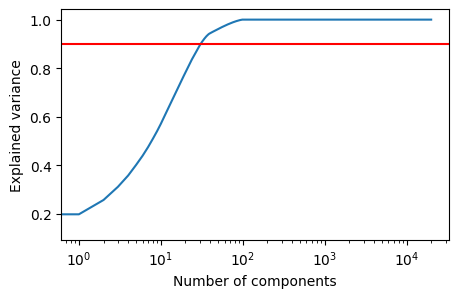

Number of components explaining 90.0% variance: 31
Number of components explaining 95.0% variance: 44
Number of components explaining 99.0% variance: 78
Number of components explaining 99.9999% variance: 99


In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xscale('log')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
# draw a line at 90% explained variance
plt.axhline(y=0.9, color='r', linestyle='-')
plt.show()

for threshold in [0.9, 0.95, 0.99, 0.999999]:
    print("Number of components explaining {}% variance: {}".format(threshold * 100, np.where(np.cumsum(pca.explained_variance_ratio_) > threshold)[0][0]))

In [4]:
sim_benchmark['pca'] = {'time': 18, 'd': 31}

### Correlation

In [25]:
# for this method, we must fulfil the condition that D is smaller than, which in this case is not going to happen
# but let's try anyways

2 * np.log10(rna_counts.shape[0])

9.90848501887865

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rna_counts = rna_counts.to(device)

In [7]:
n = rna_counts.shape[0]

def indicator_fn(x, y, epsilon):
    #if torch.cuda.is_available():
    return torch.norm(x - y, dim=1) < epsilon
    #else:
    #    return np.linalg.norm(x - y) < epsilon

# measure execution time
import time
start_time = time.time()

r_values = np.linspace(0.001, 1.0, 100)
correlation_integrals = np.zeros(len(r_values))

import tqdm

# not enough memory
#norms = torch.norm(rna_counts.unsqueeze(1) - rna_counts.unsqueeze(0), dim=1)
norms = torch.zeros(n, n)
for i in tqdm.tqdm(range(n)):
    norms[i] = torch.norm(rna_counts - rna_counts[i], dim=1)

for idx, r in enumerate(tqdm.tqdm(r_values)):
    #correlation_integrals[idx] = (2 / (n*(n-1))) * torch.sum([torch.sum(indicator_fn(rna_counts[i,:], rna_counts[i+1:,:], r)) for i in range(n)])
    # even faster: compute all against all and use triangle matrix, but not enough memory
    correlation_integrals[idx] = (2 / (n*(n-1))) * torch.sum(torch.triu(norms < r, diagonal=1))

end_time = time.time()
# return time in minutes
print("Execution time: {} minutes".format((end_time - start_time)/60))

100%|██████████| 100/100 [16:57<00:00, 10.18s/it]

Execution time: 63.6831848303477 minutes


In [40]:
# save the norms
torch.save(norms, '01_data/large_y_sim_pairwise_distances.pt')

In [12]:
# what is the minimum and maximum value of the norms upper triangle?
print(torch.min(norms[torch.triu(torch.ones(n, n), diagonal=1) == 1]))
print(torch.max(norms[torch.triu(torch.ones(n, n), diagonal=1) == 1]))

tensor(242.2432)
tensor(4388.8413)


In [13]:
r_values = np.linspace(250, 4000, 100)
for idx, r in enumerate(tqdm.tqdm(r_values)):
    #correlation_integrals[idx] = (2 / (n*(n-1))) * torch.sum([torch.sum(indicator_fn(rna_counts[i,:], rna_counts[i+1:,:], r)) for i in range(n)])
    # even faster: compute all against all and use triangle matrix, but not enough memory
    correlation_integrals[idx] = (2 / (n*(n-1))) * torch.sum(torch.triu(norms < r, diagonal=1))

100%|██████████| 100/100 [16:58<00:00, 10.19s/it]


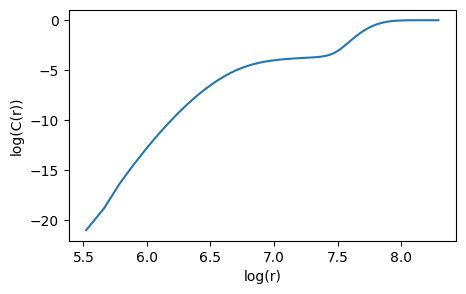

In [14]:
# log-log plot

fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(np.log(r_values), np.log(correlation_integrals))
plt.xlabel('log(r)')
plt.ylabel('log(C(r))')
plt.show()

1 5
Slope of the linear model: 17.928392892441696


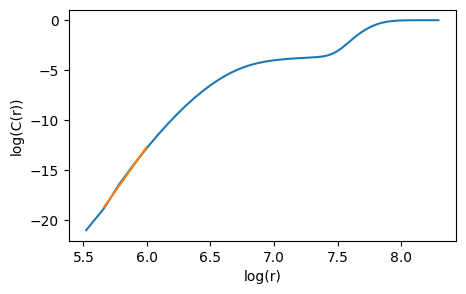

In [24]:
# fit a linear model to the log-log plot (between lor(r) = 5.5 and log(r) = 6.5)

start_idx = np.where(np.log(r_values) >= 5.6)[0][0]
end_idx = np.where(np.log(r_values) > 6.0)[0][0]
print(start_idx, end_idx)

from sklearn.linear_model import LinearRegression

# fit a linear model to the log-log plot
lr = LinearRegression()
lr.fit(np.log(r_values[start_idx:end_idx]).reshape(-1, 1), np.log(correlation_integrals[start_idx:end_idx]))

print("Slope of the linear model: {}".format(lr.coef_[0]))

# plot the linear model into the log-log plot
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(np.log(r_values), np.log(correlation_integrals))
plt.plot(np.log(r_values[start_idx:end_idx]), lr.coef_[0]*np.log(r_values[start_idx:end_idx]) + lr.intercept_)
plt.xlabel('log(r)')
plt.ylabel('log(C(r))')
plt.show()


In [25]:
sim_benchmark['correlation'] = {'time': 63, 'd': 18}

### Distance exponent

In [32]:
# for the r_values, calculate the average number of distances less than r
# the power law states that this scales proportionally to r^d

import math
avg_n_distances = np.zeros(len(r_values))

for idx, r in enumerate(tqdm.tqdm(r_values)):
    avg_n_distances[idx] = (1/sum(range(n))) * torch.sum(torch.triu(norms < r, diagonal=1))

100%|██████████| 100/100 [17:02<00:00, 10.22s/it]


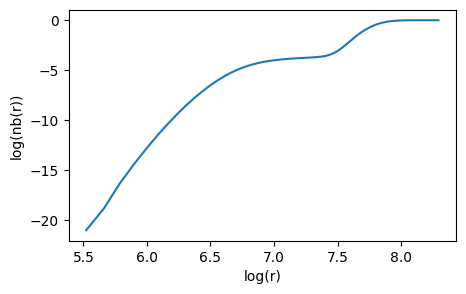

In [33]:
# log-log plot

fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(np.log(r_values), np.log(avg_n_distances))
plt.xlabel('log(r)')
plt.ylabel('log(nb(r))')
plt.show()

## Scikit-dimension

In [3]:
#!pip install scikit-dimension
import skdim
import time

In [4]:
rna_counts = rna_counts.cpu().numpy()

In [37]:
start_time = time.time()

pca_dim = skdim.id.lPCA().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 10.82130072514216 minutes
Estimated intrinsic dimension: 32


In [38]:
start_time = time.time()

pca_dim = skdim.id.CorrInt().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 20.558450043201447 minutes
Estimated intrinsic dimension: 10.646233891667121


In [11]:
start_time = time.time()

pca_dim = skdim.id.DANCo().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

KeyboardInterrupt: 

In [5]:
start_time = time.time()

pca_dim = skdim.id.ESS().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 717.8618870417278 minutes
Estimated intrinsic dimension: 23.69489582578049


In [6]:
start_time = time.time()

pca_dim = skdim.id.FisherS().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 22.988013195991517 minutes
Estimated intrinsic dimension: 4.224413382055472


In [7]:
start_time = time.time()

pca_dim = skdim.id.KNN().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 375.78503791888556 minutes
Estimated intrinsic dimension: 4


In [ ]:
start_time = time.time()

pca_dim = skdim.id.MADA().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

In [5]:
start_time = time.time()

pca_dim = skdim.id.MiND_ML().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 19.20188210407893 minutes
Estimated intrinsic dimension: 10.0


In [ ]:
start_time = time.time()

pca_dim = skdim.id.MiND_ML(k=1).fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

In [8]:
start_time = time.time()

pca_dim = skdim.id.MLE().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 10.88337740500768 minutes
Estimated intrinsic dimension: 17.184770343571504


In [6]:
start_time = time.time()

pca_dim = skdim.id.MOM().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 16.73483256896337 minutes
Estimated intrinsic dimension: 14.627227783203125


In [10]:
start_time = time.time()

pca_dim = skdim.id.TLE().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 13.199073986212413 minutes
Estimated intrinsic dimension: 17.092620510011752


In [9]:
start_time = time.time()

pca_dim = skdim.id.TwoNN().fit(rna_counts).dimension_

end_time = time.time()
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(pca_dim))

Execution time: 17.442480047543842 minutes
Estimated intrinsic dimension: 20.043295577881235


## 2010s (medium level)

### ClusterDimension

In [ ]:
# again use the norms for pairwise distances as a start
# next compute the minimum-linkage agglomerative clustering to get a hierarchical clustering

from sklearn.cluster import AgglomerativeClustering

start_time = time.time()

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='single').fit(norms)

In [ ]:
print("N clusters: ".format(clustering.n_clusters_))
print("N leaves: ".format(clustering.n_leaves_))
print("N connected components: ".format(clustering.n_connected_components_))
print("Children: ".format(clustering.children_))
print("Distances: ".format(clustering.distances_))

## 2020s (state of the art)

### Wasserstein distance

In [7]:
# version 1: euclidean distance

alpha = 2
n = (rna_counts.shape[0] / 2) / (alpha + 1)
print("alpha: {}, n: {}".format(alpha, n))

# first draw 4 random sets
available_indices = np.arange(rna_counts.shape[0])
n_1_indices = np.random.choice(available_indices, int(n), replace=False)
available_indices = list(set(available_indices) - set(n_1_indices))
n_2_indices = np.random.choice(available_indices, int(n), replace=False)
available_indices = list(set(available_indices) - set(n_2_indices))
an_1_indices = np.random.choice(available_indices, int(alpha*n), replace=False)
available_indices = list(set(available_indices) - set(an_1_indices))
an_2_indices = np.random.choice(available_indices, int(alpha*n), replace=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rna_counts = rna_counts.to(device)

# measure execution time
import time
start_time = time.time()

w_dist_n = torch.mean(torch.norm(rna_counts[n_1_indices] - rna_counts[n_2_indices], dim=1)).item()
w_dist_an = torch.mean(torch.norm(rna_counts[an_1_indices] - rna_counts[an_2_indices], dim=1)).item()

d = math.log(alpha) / (math.log(w_dist_n) - math.log(w_dist_an))

end_time = time.time()
# return time in minutes
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(d))

alpha: 2, n: 15000.0
Execution time: 0.0010131120681762696 minutes
Estimated intrinsic dimension: -210.07931191439383


In [8]:
# version 1: euclidean distance

alpha = 100
n = (rna_counts.shape[0] / 2) / (alpha + 1)
print("alpha: {}, n: {}".format(alpha, n))

# first draw 4 random sets
available_indices = np.arange(rna_counts.shape[0])
n_1_indices = np.random.choice(available_indices, int(n), replace=False)
available_indices = list(set(available_indices) - set(n_1_indices))
n_2_indices = np.random.choice(available_indices, int(n), replace=False)
available_indices = list(set(available_indices) - set(n_2_indices))
an_1_indices = np.random.choice(available_indices, int(alpha*n), replace=False)
available_indices = list(set(available_indices) - set(an_1_indices))
an_2_indices = np.random.choice(available_indices, int(alpha*n), replace=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rna_counts = rna_counts.to(device)

# measure execution time
import time
start_time = time.time()

w_dist_n = torch.mean(torch.norm(rna_counts[n_1_indices] - rna_counts[n_2_indices], dim=1)).item()
w_dist_an = torch.mean(torch.norm(rna_counts[an_1_indices] - rna_counts[an_2_indices], dim=1)).item()

d = math.log(alpha) / (math.log(w_dist_n) - math.log(w_dist_an))

end_time = time.time()
# return time in minutes
print("Execution time: {} minutes".format((end_time - start_time)/60))
print("Estimated intrinsic dimension: {}".format(d))

alpha: 100, n: 445.54455445544556
Execution time: 0.004705997308095297 minutes
Estimated intrinsic dimension: 7922.260759737396


In [9]:
# version 1: euclidean distance
ds = []

for alpha in range(2,101):
    n = (rna_counts.shape[0] / 2) / (alpha + 1)

    # first draw 4 random sets
    available_indices = np.arange(rna_counts.shape[0])
    n_1_indices = np.random.choice(available_indices, int(n), replace=False)
    available_indices = list(set(available_indices) - set(n_1_indices))
    n_2_indices = np.random.choice(available_indices, int(n), replace=False)
    available_indices = list(set(available_indices) - set(n_2_indices))
    an_1_indices = np.random.choice(available_indices, int(alpha*n), replace=False)
    available_indices = list(set(available_indices) - set(an_1_indices))
    an_2_indices = np.random.choice(available_indices, int(alpha*n), replace=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    rna_counts = rna_counts.to(device)

    # measure execution time
    #import time
    #start_time = time.time()

    w_dist_n = torch.mean(torch.norm(rna_counts[n_1_indices] - rna_counts[n_2_indices], dim=1)).item()
    w_dist_an = torch.mean(torch.norm(rna_counts[an_1_indices] - rna_counts[an_2_indices], dim=1)).item()

    d = math.log(alpha) / (math.log(w_dist_n) - math.log(w_dist_an))

    #end_time = time.time()
    ds.append(d)

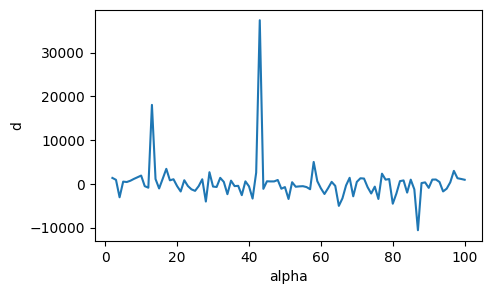

In [10]:
# plot ds against alphas
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(range(2,101), ds)
plt.xlabel('alpha')
plt.ylabel('d')
plt.show()

## Empirical estimation

In [3]:
import torch.nn as nn
import torch
import tqdm
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# I will try with running an overcomplete autoencoder with varying latent dimensions

class OvercompleteAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(OvercompleteAE, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, int(0.5*input_dim)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(0.5*input_dim), latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, int(0.5*input_dim)),
            torch.nn.ReLU(),
            torch.nn.Linear(int(0.5*input_dim), input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def parallel_linear_regression(x, y, n_samples, n_samples_train, n_epochs=100, early_stopping=10):
    import tqdm
    y_mean = y[n_samples_train:n_samples].mean(dim=0)

    # loaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x[:n_samples_train], y[:n_samples_train]), batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x[n_samples_train:n_samples], y[n_samples_train:n_samples]), batch_size=128, shuffle=False)

    # set up a linear layer to use for parallel regression
    linear = nn.Linear(x.shape[1], y.shape[1]).to(device)
    optimizer = torch.optim.Adam(linear.parameters(), lr=0.0001, weight_decay=0)
    loss_fn = nn.MSELoss()

    # train the linear layer
    val_losses = []
    pbar = tqdm.tqdm(range(n_epochs))
    for epoch in pbar:
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = linear(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        val_loss = 0
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred = linear(x_val)
            val_loss += loss_fn(y_pred, y_val).item()
        val_losses.append(val_loss / len(val_loader))
        if epoch > early_stopping and min(val_losses[-early_stopping:]) > min(val_losses):
            print("Early stopping in linear regression at epoch ", epoch)
            break
        #pbar.set_postfix({'val loss': round(val_loss / len(val_loader), 4)})
    
    y_pred = linear(x[n_samples_train:n_samples].to(device)).cpu()
    y_pred = y_pred.detach()
    r_squares = 1 - (((y[n_samples_train:n_samples] - y_pred)**2).sum(0) / ((y[n_samples_train:n_samples] - y_mean)**2).sum(0))
    return r_squares

def train_overcomplete_ae(data, n_samples_train, latent_dim, epochs=100, early_stopping=10, lr=0.001):
    # set the random seed
    torch.manual_seed(0)

    # set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # create the model
    model = OvercompleteAE(data.shape[1], latent_dim).to(device)

    # create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # create the loss function
    loss_fn = torch.nn.MSELoss()

    # create the data loader
    data_loader = torch.utils.data.DataLoader(data[:n_samples_train], batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(data[n_samples_train:], batch_size=128, shuffle=False)

    # train the model
    train_losses = []
    #val_losses = []
    pbar = tqdm.tqdm(range(epochs))
    for epoch in pbar:
        train_losses.append(0)
        for x in data_loader:
            x = x.to(device)
            # forward pass
            x_hat = model(x)
            # compute the loss
            loss = loss_fn(x_hat, x)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass
            loss.backward()
            # update the weights
            optimizer.step()
            train_losses[-1] += loss.item()
        train_losses[-1] /= len(data_loader)
        pbar.set_postfix({'loss': round(train_losses[-1], 4)})
        
        # compute the validation loss
        #val_losses.append(0)
        #for x in val_loader:
        #    x = x.to(device)
        #    x_hat = model(x)
        #    val_losses[-1] += loss_fn(x_hat, x).item()
        #val_losses[-1] /= len(val_loader)

        #if epoch > early_stopping and min(val_losses[-early_stopping:]) > min(val_losses):
        #    break
    # empty cache
    torch.cuda.empty_cache()
    gc.collect()

    # calculate the superpositions of the data in the latent space
    reps = model.encoder(data[:n_samples_train].to(device)).cpu().detach()
    r_squares = parallel_linear_regression(reps, data[:n_samples_train], n_samples_train, int(n_samples_train*0.9), n_epochs=100, early_stopping=10)
    # remove all nan and inf values
    r_squares = r_squares[torch.isfinite(r_squares)]

    return np.mean(train_losses[-5:]), r_squares.mean().item()

In [4]:
data_fraction = 0.3

latent_min = 20
latent_max = 1000
latent_dims = [latent_min, latent_max]

# first get metrics for the min and max latent dimensions
train_losses_max, r_squares_max = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), latent_max, epochs=50, lr=0.0001)
print("Latent dim: {}, train loss: {}, r_square: {}".format(latent_max, train_losses_max, r_squares_max))
train_losses_min, r_squares_min = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), latent_min, epochs=50, lr=0.0001)
print("Latent dim: {}, train loss: {}, r_square: {}".format(latent_min, train_losses_min, r_squares_min))
losses = [train_losses_min, train_losses_max]
r_squares = [r_squares_min, r_squares_max]

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Latent dim: 1000, train loss: 0.2662339781274162, r_square: 0.9993726015090942


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Latent dim: 20, train loss: 4.239694313980392, r_square: 0.6148912310600281


In [8]:
# we employ a search for the optimal latent dimension by looking at when loss increases and r_squares decrease
steps = 5

while steps > 0:
    next_latent = int((latent_min + latent_max) / 2)
    print("Next latent dimension: ", next_latent)
    train_losses_temp, r_squares_temp = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), next_latent, epochs=50, lr=0.0001)
    latent_dims.append(next_latent)
    losses.append(train_losses_temp)
    r_squares.append(r_squares_temp)
    print("Latent dim: {}, train loss: {}, r_square: {}".format(next_latent, train_losses_temp, r_squares_temp))
    loss_diffs = [np.abs(train_losses_temp - train_losses_min), np.abs(train_losses_temp - train_losses_max)]
    r_square_diffs = [np.abs(r_squares_temp - r_squares_min), np.abs(r_squares_temp - r_squares_max)]
    if loss_diffs[0] < loss_diffs[1] and r_square_diffs[0] < r_square_diffs[1]:
        latent_min = next_latent
        train_losses_min = train_losses_temp
        r_squares_min = r_squares_temp
    elif loss_diffs[0] > loss_diffs[1] and r_square_diffs[0] > r_square_diffs[1]:
        latent_max = next_latent
        train_losses_max = train_losses_temp
        r_squares_max = r_squares_temp
    else:
        print("   results not consistent")
        if r_square_diffs[0] < r_square_diffs[1]:
            latent_min = next_latent
            train_losses_min = train_losses_temp
            r_squares_min = r_squares_temp
        else:
            latent_max = next_latent
            train_losses_max = train_losses_temp
            r_squares_max = r_squares_temp
    steps -= 1

Next latent dimension:  510


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Latent dim: 510, train loss: 0.2508564626930449, r_square: 0.9989874362945557
Next latent dimension:  265


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Latent dim: 265, train loss: 0.29890611663248867, r_square: 0.9989351034164429
Next latent dimension:  142


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Latent dim: 142, train loss: 0.3164930015378654, r_square: 0.9990155696868896
Next latent dimension:  81


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Latent dim: 81, train loss: 0.3225435485207074, r_square: 0.9774366617202759
Next latent dimension:  50


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Latent dim: 50, train loss: 0.6997293575115113, r_square: 0.9241017699241638


In [9]:
next_latent = int((142 + 81) / 2)
print("Next latent dimension: ", next_latent)
train_losses_temp, r_squares_temp = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), next_latent, epochs=50, lr=0.0001)
latent_dims.append(next_latent)
losses.append(train_losses_temp)
r_squares.append(r_squares_temp)
print("Latent dim: {}, train loss: {}, r_square: {}".format(next_latent, train_losses_temp, r_squares_temp))

Next latent dimension:  111


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Latent dim: 111, train loss: 0.2945102153231183, r_square: 0.9993739128112793


In [10]:
next_latent = int((142 + 111) / 2)
print("Next latent dimension: ", next_latent)
train_losses_temp, r_squares_temp = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), next_latent, epochs=50, lr=0.0001)
latent_dims.append(next_latent)
losses.append(train_losses_temp)
r_squares.append(r_squares_temp)
print("Latent dim: {}, train loss: {}, r_square: {}".format(next_latent, train_losses_temp, r_squares_temp))

Next latent dimension:  126


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Latent dim: 126, train loss: 0.3045046741222318, r_square: 0.9992056488990784


In [15]:
next_latent = int((111 + 81) / 2)
print("Next latent dimension: ", next_latent)
train_losses_temp, r_squares_temp = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), next_latent, epochs=50, lr=0.0001)
latent_dims.append(next_latent)
losses.append(train_losses_temp)
r_squares.append(r_squares_temp)
print("Latent dim: {}, train loss: {}, r_square: {}".format(next_latent, train_losses_temp, r_squares_temp))

Next latent dimension:  96


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Latent dim: 96, train loss: 0.28532323989822966, r_square: 0.9935515522956848


In [23]:
next_latent = int((111 + 96) / 2)
print("Next latent dimension: ", next_latent)
train_losses_temp, r_squares_temp = train_overcomplete_ae(rna_counts, int(n_samples_train*data_fraction), next_latent, epochs=50, lr=0.0001)
latent_dims.append(next_latent)
losses.append(train_losses_temp)
r_squares.append(r_squares_temp)
print("Latent dim: {}, train loss: {}, r_square: {}".format(next_latent, train_losses_temp, r_squares_temp))

Next latent dimension:  103


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Latent dim: 103, train loss: 0.2887132367957824, r_square: 0.9993582963943481


stop when the space is covered +- 10% around the last latent dim that gives 1.0 R^2 (rounded to 2 decimals)

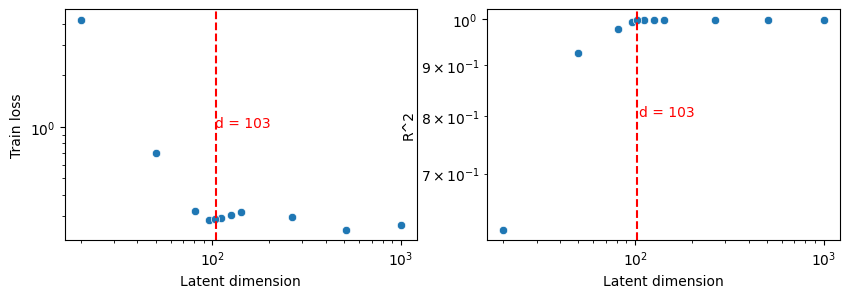

In [28]:
# plot the losses and r_squares against latent dimensions
plot_df = pd.DataFrame({'latent_dim': latent_dims, 'loss': losses, 'r_square': r_squares})

best_latent = 103
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(data=plot_df, x='latent_dim', y='loss', ax=ax[0])
# plot a line at latent_dim = 96
ax[0].axvline(x=best_latent+2, color='r', linestyle='--')
# add text
ax[0].text(best_latent, 1, f"d = {best_latent}", color='r')
ax[0].set_xlabel('Latent dimension')
ax[0].set_ylabel('Train loss')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
sns.scatterplot(data=plot_df, x='latent_dim', y='r_square', ax=ax[1])
ax[1].axvline(x=best_latent, color='r', linestyle='--')
ax[1].text(best_latent+2, 0.8, f"d = {best_latent}", color='r')
ax[1].set_xlabel('Latent dimension')
ax[1].set_ylabel('R^2')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
plt.show()

In [29]:
plot_df

,latent_dim,loss,r_square
0,20,4.239694,0.614891
1,1000,0.266234,0.999373
2,510,0.250856,0.998987
3,265,0.298906,0.998935
4,142,0.316493,0.999016
5,81,0.322544,0.977437
6,50,0.699729,0.924102
7,111,0.294510,0.999374
8,126,0.304505,0.999206
9,96,0.285323,0.993552


## Other tests

### distance batch svd

In [ ]:
unique_norm_values = torch.triu(norms, diagonal=1).flatten().unique()
# reduce the precision and call unique again
unique_norm_values = unique_norm_values.to(torch.float16)
unique_norm_values = unique_norm_values.unique()
# back to double
unique_norm_values = unique_norm_values.to(torch.float64)
print("Unique norm values: ", len(unique_norm_values))

Unique norm values:  4029


In [15]:
quantile = 0.95
norms_threshold = torch.quantile(unique_norm_values, quantile).item()
print("Threshold for {}-quantile: {}".format(quantile, norms_threshold))

Threshold for 0.95-quantile: 3825.2


In [19]:
# choose all indices where the norm is above the threshold
#indices = torch.where(norms > norms_threshold)
indices = list(set((torch.where(norms > norms_threshold)[0]).tolist()))
print(len(indices))

10311


In [21]:
# now take the rows of the most diverse pairs and compute a singular value decomposition
s = torch.linalg.svdvals(rna_counts[indices,:])

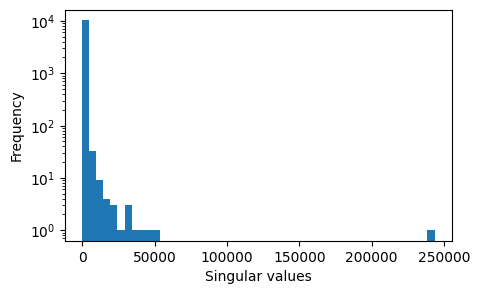

In [24]:
# plot a histogram of s
fig, ax = plt.subplots(figsize=(5, 3))
plt.hist(s, bins=50)
plt.xlabel('Singular values')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [25]:
# how many singular values are above 1?
print("Number of singular values above 1: ", len(s[s > 1]))

Number of singular values above 1:  100


In [28]:
# how many singular values are above 1?
print("Number of singular values above 1: ", len(s[s > 1e-4]))
print("Number of singular values above 1: ", len(s[s > 1e-3]))
print("Number of singular values above 1: ", len(s[s > 1e-2]))
print("Number of singular values above 1: ", len(s[s > 1e-1]))

Number of singular values above 1:  9102
Number of singular values above 1:  244
Number of singular values above 1:  114
Number of singular values above 1:  100


# Estimation

In [2]:
method_name = ['PCA_90', 'PCA_99', 'Correlation', 'Distance_Exponent', 'PCA_skdim', 'Correlation_skdim', 'DANCo_skdim', 'ESS_skdim', 'FisherS_skdim', 'kNN_skdim', 'MADA_skdim', 'MiND_ML_skdim', 'MLE_skdim', 'MOM_skdim', 'TLE_skdim', 'TwoNN_skdim', 'AE_Superposition']
exec_times = [18, 18, 64, 64, 11, 25, None, 718, 23, 376, None, 19, 11, 17, 13, 17, 26+62+4*12]
dimensions = [31, 78, 18, 18, 32, 11, None, 24, 4, 4, None, 10, 17, 15, 17, 20, 103]

/tmp/ipykernel_184932/2413666372.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
/tmp/ipykernel_184932/2413666372.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)


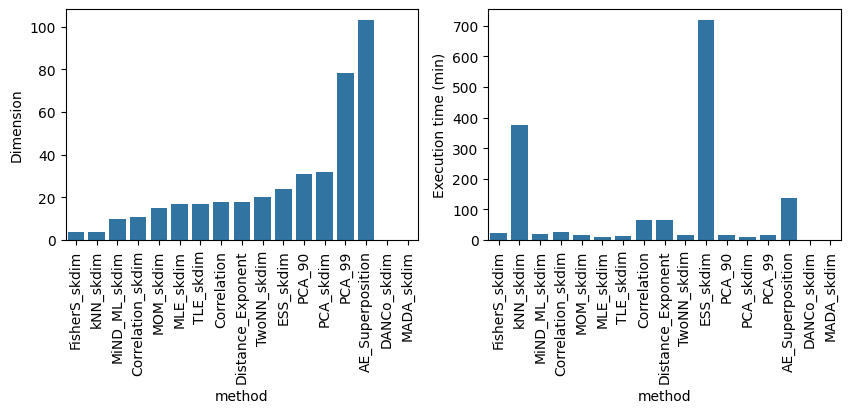

In [4]:
# plot the execution times and dimensions
plot_df2 = pd.DataFrame({'method': method_name, 'execution_time': exec_times, 'dimension': dimensions})
# sort by dimension
plot_df2 = plot_df2.sort_values(by='dimension', ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.barplot(data=plot_df2, x='method', y='execution_time', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_ylabel('Execution time (min)')
sns.barplot(data=plot_df2, x='method', y='dimension', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylabel('Dimension')
plt.show()